# Kawempe Grid-Based Risk Features and ML Exploration

This notebook creates a uniform 250m grid over Kawempe, computes per-cell urban risk indicators (NDVI, buildings, services, roads), and performs basic ML clustering.

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import box
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Load NDVI Raster and Define Grid Area

<Axes: >

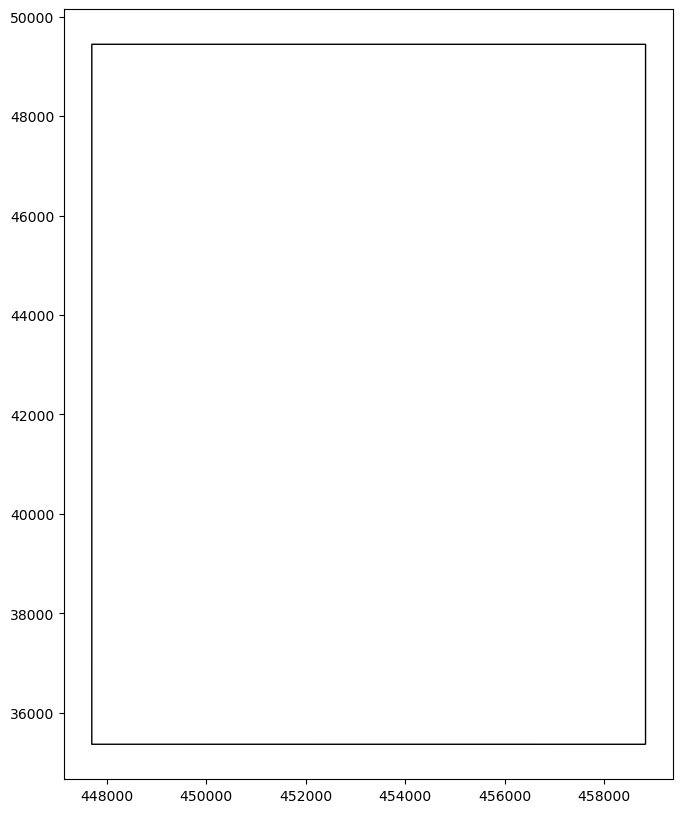

In [20]:
from shapely.geometry import box

# Load and reproject OSM layers to NDVI CRS
buildings = gpd.read_file("../data/raw/kawempe_buildings.geojson")
roads = gpd.read_file("../data/raw/kawempe_roads.geojson")
services = gpd.read_file("../data/raw/kawempe_services.geojson")

# NVDI path
ndvi_path = "../data/raw/Kawempe_NDVI_2023.tif"

with rasterio.open(ndvi_path) as src:
    raster_bounds = src.bounds
    raster_crs = src.crs

# Reproject all to match raster CRS
buildings = buildings.to_crs(raster_crs)
roads = roads.to_crs(raster_crs)
services = services.to_crs(raster_crs)

# Get total bounds from all layers
b_all = buildings.total_bounds
r_all = roads.total_bounds
s_all = services.total_bounds

# Combine bounds into one larger extent
xmin = min(raster_bounds.left, b_all[0], r_all[0], s_all[0])
ymin = min(raster_bounds.bottom, b_all[1], r_all[1], s_all[1])
xmax = max(raster_bounds.right, b_all[2], r_all[2], s_all[2])
ymax = max(raster_bounds.top, b_all[3], r_all[3], s_all[3])

# Create a bounding box
bbox = box(xmin, ymin, xmax, ymax)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=raster_crs).to_crs("EPSG:32636")

# Plot to confirm
bbox_gdf.plot(edgecolor='black', facecolor='none', figsize=(10, 10))


## Create Uniform Grid

Generated 35 grid cells of size 2000m × 2000m


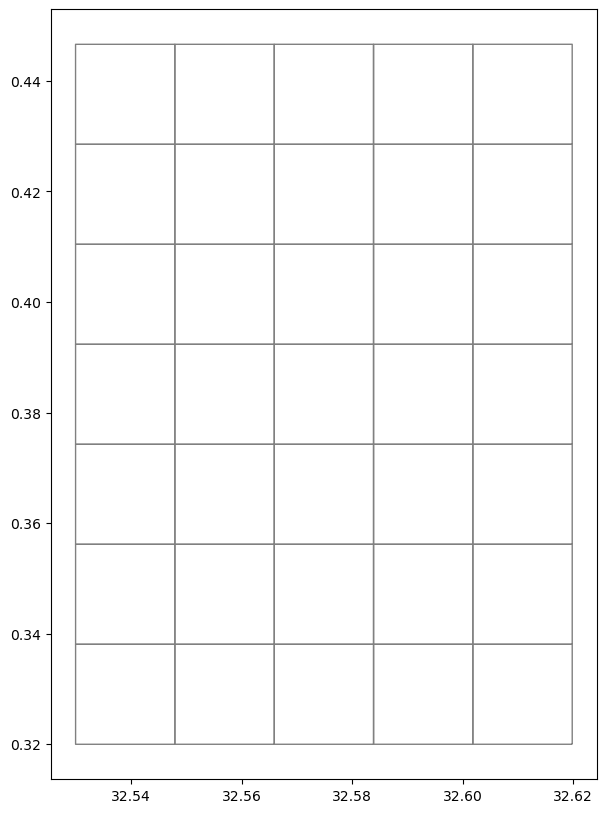

In [21]:
grid_size = 2000 # 2 km
xmin, ymin, xmax, ymax = bbox_gdf.total_bounds
rows = int((ymax - ymin) / grid_size)
cols = int((xmax - xmin) / grid_size)
grid_cells = [box(xmin + i * grid_size, ymin + j * grid_size,
                  xmin + (i + 1) * grid_size, ymin + (j + 1) * grid_size)
              for i in range(cols) for j in range(rows)]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:32636').to_crs('EPSG:4326')
grid.plot(edgecolor='gray', facecolor='none', figsize=(10, 10))

print(f"Generated {len(grid)} grid cells of size {grid_size}m × {grid_size}m")


## Compute NDVI per Grid Cell

In [22]:
stats = zonal_stats(grid.to_json(), ndvi_path, stats=['mean'], geojson_out=True)
ndvi_grid = gpd.GeoDataFrame.from_features(stats).set_crs('EPSG:4326')
ndvi_grid = ndvi_grid.rename(columns={'mean': 'mean_ndvi'})
print(ndvi_grid.count())
ndvi_grid.head()

geometry     35
mean_ndvi    35
dtype: int64


,geometry,mean_ndvi
0,"POLYGON ((32.54795 0.31998, 32.54795 0.33807, ...",0.167570
1,"POLYGON ((32.54795 0.33807, 32.54794 0.35616, ...",0.213353
2,"POLYGON ((32.54794 0.35616, 32.54794 0.37426, ...",0.168311
3,"POLYGON ((32.54794 0.37426, 32.54794 0.39235, ...",0.055386
4,"POLYGON ((32.54794 0.39235, 32.54794 0.41045, ...",0.000000


In [23]:
print("Grid cells with valid NDVI:", ndvi_grid['mean_ndvi'].notna().sum())
print("Grid cells without NDVI:", ndvi_grid['mean_ndvi'].isna().sum())

Grid cells with valid NDVI: 35
Grid cells without NDVI: 0


## Count Features per Grid Cell and Show Plot

In [24]:
# Building count
bldg_join = gpd.sjoin(buildings, ndvi_grid, predicate='within')
bldg_count = bldg_join.groupby(bldg_join.index_right).size()
ndvi_grid['building_count'] = ndvi_grid.index.map(bldg_count).fillna(0)

# Service count
svc_join = gpd.sjoin(services, ndvi_grid, predicate='within')
svc_count = svc_join.groupby(svc_join.index_right).size()
ndvi_grid['service_count'] = ndvi_grid.index.map(svc_count).fillna(0)

# Road length
roads_proj = roads.to_crs('EPSG:32636')
roads_proj['length_km'] = roads_proj.length / 1000
grid_proj = ndvi_grid.to_crs('EPSG:32636')
road_join = gpd.sjoin(roads_proj, grid_proj, predicate='within')
road_length = road_join.groupby(road_join.index_right)['length_km'].sum()
ndvi_grid['road_km'] = ndvi_grid.index.map(road_length).fillna(0)

# Population
pop_data = gpd.read_file("../data/processed/kawempe_grid_with_population.geojson")
ndvi_grid = gpd.sjoin(ndvi_grid, pop_data[["geometry", "pop_est"]], predicate="intersects", how="left")
ndvi_grid = ndvi_grid.drop(columns=[col for col in ndvi_grid.columns if col.startswith("index_")])
ndvi_grid["pop_est"] = ndvi_grid["pop_est"].fillna(0).astype(int)


In [35]:
# Mask low-activity cells
mask = (
    (ndvi_grid["building_count"] < 500) &
    (ndvi_grid["service_count"] < 10) &
    (ndvi_grid["road_km"] < 10)
)

# Define small scaling weights
w_b = 2      # each building = ~2 people
w_s = 5      # each service = ~5 people
w_r = 10     # each km of road = ~10 people

# Assign small non-zero estimated population using weighted logic
ndvi_grid.loc[mask, "pop_est"] = (
    w_b * ndvi_grid["building_count"] +
    w_s * ndvi_grid["service_count"] +
    w_r * ndvi_grid["road_km"]
)[mask].astype(int)


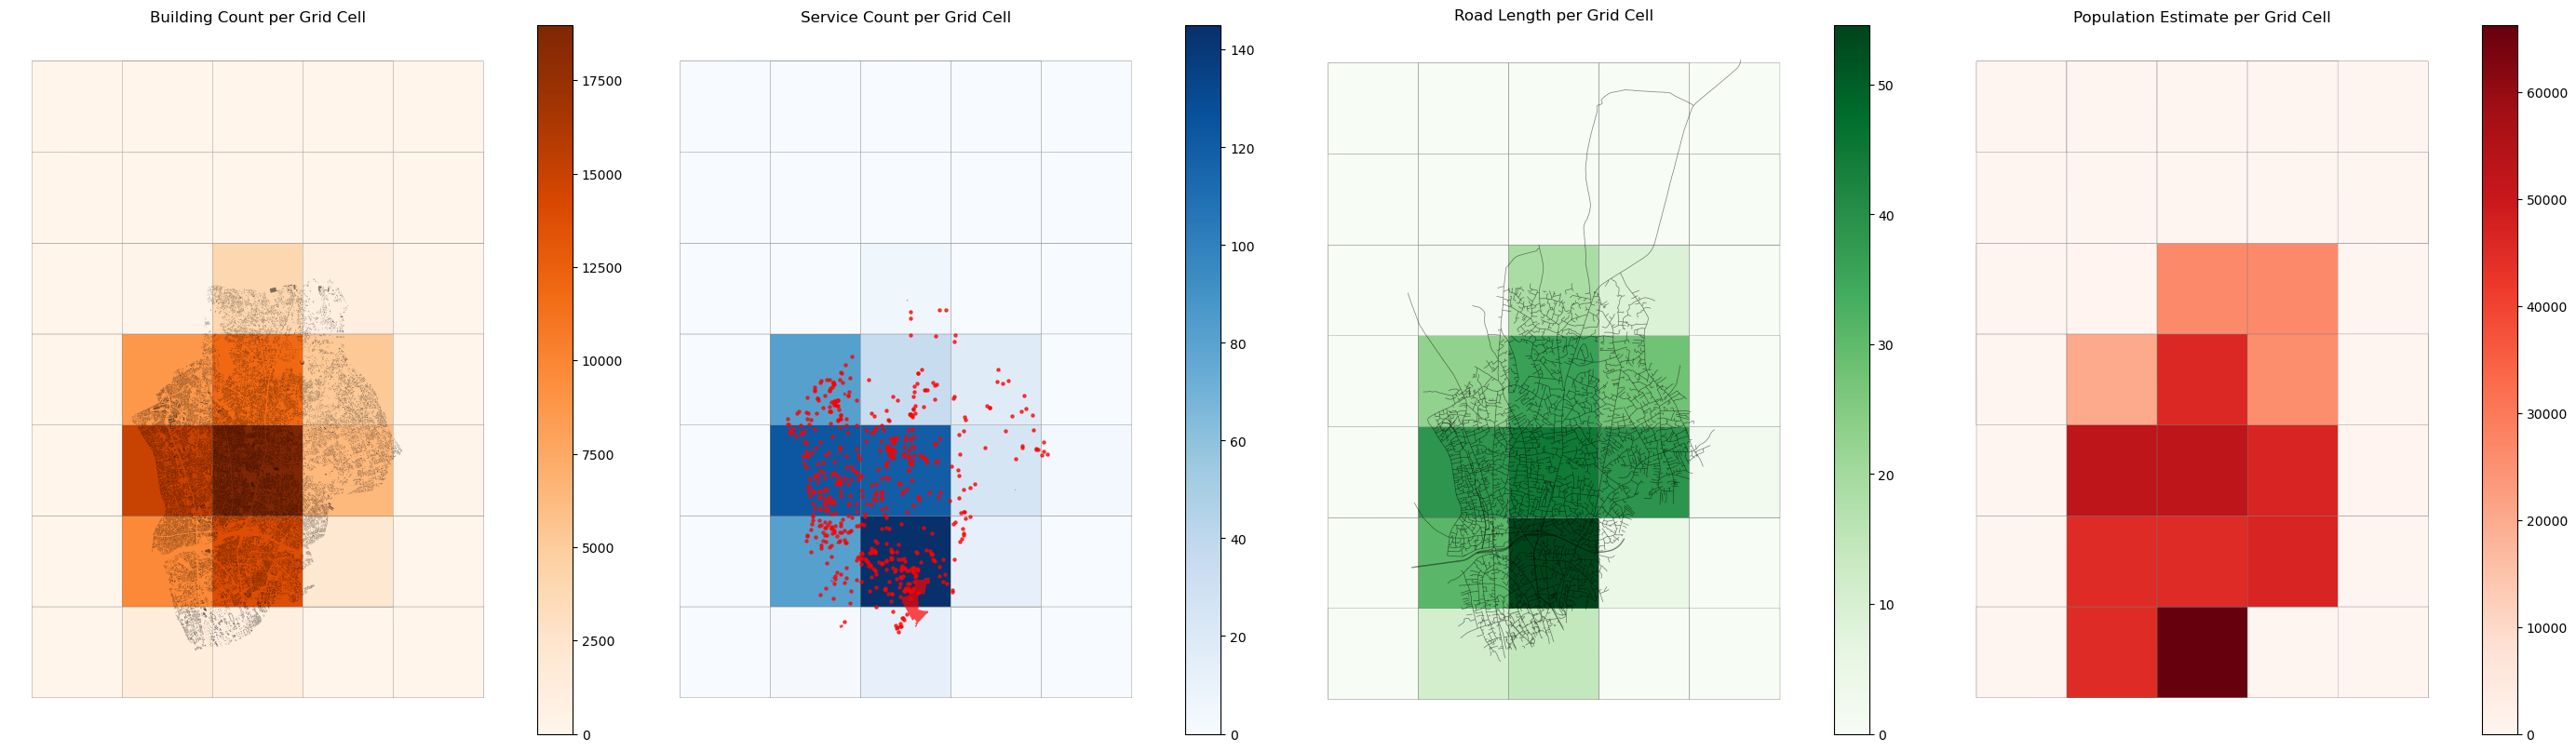

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(28, 8))

# Plot 1: Building Count
ndvi_grid.plot(column="building_count", cmap="Oranges", legend=True,
               edgecolor="gray", linewidth=0.2, ax=axs[0])
buildings.plot(ax=axs[0], color="black", markersize=0.5, alpha=0.5)
axs[0].set_title("Building Count per Grid Cell")
axs[0].axis("off")

# Plot 2: Service Count
ndvi_grid.plot(column="service_count", cmap="Blues", legend=True,
               edgecolor="gray", linewidth=0.2, ax=axs[1])
services.plot(ax=axs[1], color="red", markersize=5, alpha=0.7)
axs[1].set_title("Service Count per Grid Cell")
axs[1].axis("off")

# Plot 3: Road Length
ndvi_grid.plot(column="road_km", cmap="Greens", legend=True,
               edgecolor="gray", linewidth=0.2, ax=axs[2])
roads.plot(ax=axs[2], color="black", linewidth=0.5, alpha=0.5)
axs[2].set_title("Road Length per Grid Cell")
axs[2].axis("off")

# Plot 4: Population
ndvi_grid.plot(column="pop_est", cmap="Reds", legend=True,
               edgecolor="gray", linewidth=0.2, ax=axs[3])
axs[3].set_title("Population Estimate per Grid Cell")
axs[3].axis("off")

plt.tight_layout()
plt.show()


## Normalize Features and Create Risk Score

In [38]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant features
feature_cols = ['mean_ndvi', 'building_count', 'service_count', 'road_km', 'pop_est']

# Create a copy of the features
features = ndvi_grid[feature_cols].copy()

# Invert NDVI: higher vegetation = lower risk
features['inv_ndvi'] = 1 - features['mean_ndvi']
features = features.drop(columns='mean_ndvi')

features_to_scale = ["inv_ndvi", "building_count", "service_count", "road_km", "pop_est"]
scaler = MinMaxScaler()

ndvi_grid[[f"{col}_scaled" for col in features_to_scale]] = scaler.fit_transform(
    features[features_to_scale]
)


In [39]:
# check scaled data

ndvi_grid[['inv_ndvi_scaled', 'building_count_scaled', 'service_count_scaled', 'road_km_scaled', 'pop_est_scaled']].describe()


,inv_ndvi_scaled,building_count_scaled,service_count_scaled,road_km_scaled,pop_est_scaled
count,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.707509,0.175588,0.157608,0.214018,0.276268
std,0.303222,0.298564,0.300434,0.311102,0.338318
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.445874,0.000000,0.000000,0.000000,0.000000
50%,0.801020,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.199700,0.124138,0.420558,0.657255
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Vulnerability (Risk) Score

In [40]:
# Combine all scaled features into a single risk score
ndvi_grid["risk_score"] = (
    ndvi_grid["inv_ndvi_scaled"] +
    ndvi_grid["building_count_scaled"] +
    ndvi_grid["service_count_scaled"] +
    ndvi_grid["road_km_scaled"] +
    ndvi_grid["pop_est_scaled"]
)


## Risk Classification using qcut

In [41]:
# First apply qcut without labels to see how many bins were actually created
bins = pd.qcut(ndvi_grid['risk_score'], q=4, duplicates='drop')

# Get the number of unique bins (will be <= 4 if duplicates were dropped)
n_bins = len(bins.cat.categories)

# Assign labels based on how many bins were actually created
labels_map = ['Low', 'Medium', 'High', 'Very High'][:n_bins]

# Apply qcut again, now with the correct number of labels
ndvi_grid['risk_level'] = pd.qcut(
    ndvi_grid['risk_score'], 
    q=4, 
    labels=labels_map,
    duplicates='drop'
)


## Visualize Clustering Results

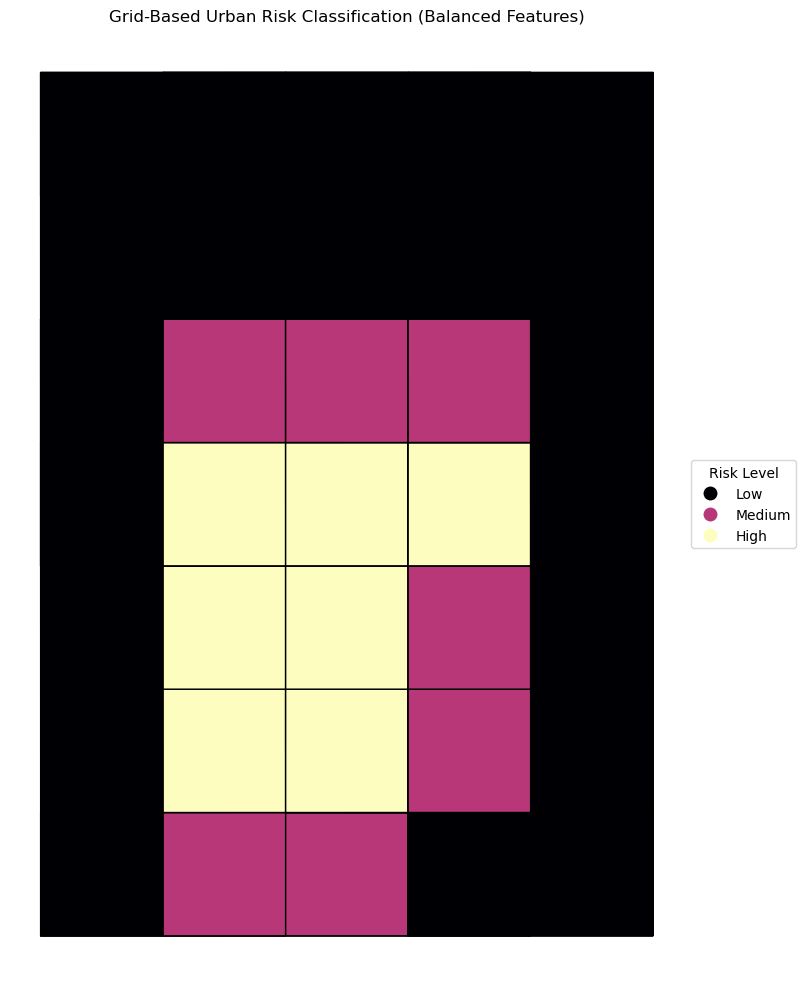

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ndvi_grid.plot(column='risk_level', cmap='magma', legend=True,
               edgecolor='black', ax=ax,
               legend_kwds={'title': 'Risk Level', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
plt.title("Grid-Based Urban Risk Classification (Balanced Features)")
plt.axis("off")
plt.tight_layout()
plt.show()

## Save Results

In [47]:
ndvi_grid.to_file('../data/processed/kawempe_grid_features.geojson', driver='GeoJSON')